In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import qutip.control.fidcomp as fidcomp
import picos
import pickle
import time

In [9]:
import qutip
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, sigmam, tensor
import qutip.logging_utils as logging
import qutip
logger = logging.get_logger()
log_level = logging.INFO
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

# Set up

In [10]:
nq = 3 #number of qubits
evo_time = 10 #annealing time
n_ts = evo_time*10 #time steps 
tlist = np.linspace(0, evo_time, n_ts)

In [11]:
#set matrices for each Hamiltonian terms, X_i, Z_i, and Z_iZ_i+1
Hx_local,Hz_local,Hz_2local=[],[],[]
for i in range(nq):
    argsX=[qutip.qeye(2) for _ in range(nq)]; argsX[i]=qutip.sigmax()
    argsZ=[qutip.qeye(2) for _ in range(nq)]; argsZ[i]=qutip.sigmaz()
    Hx_local.append(qutip.tensor(*argsX)); Hz_local.append(qutip.tensor(*argsZ))
    
    if i < nq-1:
        argsZZ=[qutip.qeye(2) for _ in range(nq)]; argsZZ[i]=qutip.sigmaz(); argsZZ[i+1]=qutip.sigmaz()
        Hz_2local.append(qutip.tensor(*argsZZ))

In [12]:
def generate_ham(hamiltonian, pauli,k):
    if pauli == 'X':
        return hamiltonian[k]
    elif pauli == 'Z':
        return hamiltonian[k]

In [13]:
H_d = 0 # driving H
for hz2 in Hz_2local:
    H_d += -hz2
H_c = [generate_ham(Hx_local, 'X', i) for i in range(nq)] + [generate_ham(Hz_local, 'Z', i) for i in range(nq)] #control H
n_ctrls = len(H_c) # number of controls

psi_0 = qutip.basis(2**nq, 2**nq - 1)# initial state

In [14]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 10000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300

#pulse bound if needed
#lbound = [-1]*2*nq; ubound = [1]*2*nq

In [15]:
for i in range(nq):
    argsZ=[qutip.qeye(2) for _ in range(nq)]; argsZ[0]=qutip.sigmaz()#qutip.basis(2,0)*qutip.basis(2,0).dag()

D0 = qutip.tensor(*argsZ)
D0.dims=[[2**nq],[2**nq]]
D0

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]

In [16]:
psi_targ = 1/np.sqrt(2)*(qutip.basis(2**nq, 0) + qutip.basis(2**nq, 2**nq-1))
rho_targ = psi_targ * psi_targ.dag()
rho_targ #targer state

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0.5]]

In [17]:
optim = cpo.create_pulse_optimizer(H_d, H_c, psi_0, D0, n_ts, evo_time, 
                                   #amp_lbound=lbound, amp_ubound=ubound,
                fid_err_targ=1e-5, 
                max_iter=10, max_wall_time=max_wall_time,
                alg='GRAPE', 
                dyn_type='UNIT', fid_type = 'CUSTOM',#'UNIT',
                log_level=log_level, gen_stats=True, rhotarg = rho_targ)

In [18]:
dyn = optim.dynamics

# Initial pulse

In [19]:
x = [np.sin(10*k/evo_time) for k in tlist]; z = [np.cos(10*k/evo_time) for k in tlist]

In [20]:
init_pulse = np.array([x])
for i in range(nq-1):
    init_pulse = np.concatenate((init_pulse, [x]))
for i in range(nq):
    init_pulse = np.concatenate((init_pulse, [z]))
    
init_pulse = init_pulse.T
init_dis = init_pulse

In [21]:
dyn.initialize_controls(init_pulse)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False


# HQuGAN using GRAPE

In [22]:
#set different options for discriminator 
#dis = 'Helstrom'
dis = 'd'
#dis = 'w'

In [23]:
tD, tP, tF, tS = [],[],[],[]

for i in range(500):
    
    pulse_list, D_list = [], []
    
    #generator 
    
    print(str(i) + "th iteration begins.")
    
    pulse_list.append(init_pulse)

    if i == 0:
        
        result = optim.run_optimization()
        D=D0
        
    else:
        result = optim1.run_optimization()
        
    
        
        
    #Generator is finished
    rhot = result.evo_full_final*result.evo_full_final.dag()
    print('Final cost: ' + str((D*(rhot-rho_targ)).tr()**2))
    
    print('Fidelity: ' + str((qutip.fidelity(result.evo_full_final, psi_targ))**2))
    tF.append((qutip.fidelity(result.evo_full_final, psi_targ))**2)
    
    if (qutip.fidelity(result.evo_full_final, psi_targ))**2 > 0.999:
        pulse_list.append(result.final_amps)
        
        init_pulse = result.final_amps
        tP.append(pulse_list)
        
        break
        
        
    #Update params
    
    
    #Discriminator
    
    if dis == 'Helstrom':

        pm = (rhot-rho_targ).eigenstates()[1][-1]*(rhot-rho_targ).eigenstates()[1][-1].dag()
        pn = (rhot-rho_targ).eigenstates()[1][0]*(rhot-rho_targ).eigenstates()[1][0].dag()


        D = 0.5*(pm - pn)
        D.dims = [[2**nq], [2**nq]]
        D_list.append(D)
        #print('Trace :' + str((D*(rhot-rho_targ)).tr()))
        
    else:
    
        optim_dis = cpo.create_pulse_optimizer(H_d, H_c, psi_0, D0, n_ts, evo_time, 
                                           #amp_lbound=lbound, amp_ubound=ubound,
                        fid_err_targ=0.01, 
                        max_iter=50, #max_wall_time=max_wall_time,
                        alg='GRAPE', #optim_method = 'FMIN_BFGS',
                        dyn_type='UNIT', fid_type = 'DIS',
                        log_level=log_level, gen_stats=True, rhodiff = (rhot-rho_targ))

        dyn_dis = optim_dis.dynamics
        dyn_dis.initialize_controls(init_dis)
        result_dis = optim_dis.run_optimization()
        
        
        U=np.diag([1]*dyn.target.shape[0])
        for i in range(n_ts-1,-1,-1):
            U=U.dot(np.matrix(dyn_dis.prop[i]))
        D = qutip.Qobj(U.conj().T.dot(np.array(D0)).dot(U))
        D_list.append(D)

    
    
    optim1 = cpo.create_pulse_optimizer(H_d, H_c, psi_0, D, n_ts, evo_time, 
                                       #amp_lbound=lbound, amp_ubound=ubound,
                    fid_err_targ=1e-5, 
                    max_iter=10, max_wall_time=max_wall_time,
                    alg='GRAPE', #optim_method = 'FMIN_BFGS',
                    dyn_type='UNIT', fid_type = 'CUSTOM',
                    log_level=log_level, gen_stats=True, rhotarg = rho_targ)


    dyn = optim1.dynamics
    
    
    init_pulse = result.final_amps
    dyn.initialize_controls(init_pulse)

    
    tP.append(pulse_list); tD.append(D_list)
    
        


INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


0th iteration begins.
gradient norm for G: 0.027578620390575324


/Users/leeseok/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/lbfgsb.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.8827523158063839
Final cost: 3.4307286238832404e-06
Fidelity: 0.3053285325986641
(1.6909948674116873+0j)
(1.6909948674116873+0j)
gradient norm for D: 1.7353850763931213
(0.8673259347000317-5.204170427930421e-18j)
gradient norm for D: 1.1498728493742523
(0.6157226253130696-2.6020852139652106e-18j)
gradient norm for D: 0.5408620271497733
(0.4649992688134388-2.6237692574149207e-17j)
gradient norm for D: 0.4831752271223085
(0.3747393724568926-7.589415207398531e-17j)
gradient norm for D: 0.34300691606290173
(0.3381050831322563-5.4643789493269423e-17j)
gradient norm for D: 0.10509639263412769
(0.3346399707790708-1.8431436932253575e-17j)
gradient norm for D: 0.042861330767964285
(0.3338499702033131-4.2500725161431774e-17j)
gradient norm for D: 0.026787754254656928
(0.33311246477983647+7.19910242530375e-17j)
gradient norm for D: 0.009091390059712441
(0.3330921383341785-6.678685382510707e-17j)
gradient norm for D: 0.011246618675991424
(0.33306223997042217+2.08166817117216

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 9.262905037847729e-05
(0.3330609111514389-5.811323644522304e-17j)
1th iteration begins.
gradient norm for G: 2.4826595230229898
gradient norm for G: 1.2319592109215087


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.056654819470169884
Final cost: 2.985880586879375e-06
Fidelity: 0.6313449117213401
(2.1362912488712174-2.3418766925686896e-17j)
(2.1362912488712174-2.3418766925686896e-17j)
gradient norm for D: 0.8774974888346248
(1.4784967748278315+2.862293735361732e-17j)
gradient norm for D: 0.5913747747175608
(1.1149402038383847-3.8163916471489756e-17j)
gradient norm for D: 0.7824943310522684
(0.9352153134076202+2.7755575615628914e-17j)
gradient norm for D: 0.6185417026115896
(0.8149719320393252+3.7730235602495554e-17j)
gradient norm for D: 0.18907819471187307
(0.7936814492252433+4.2500725161431774e-17j)
gradient norm for D: 0.10887937929691395
(0.7866359934970593-2.688821387764051e-17j)
gradient norm for D: 0.038968238697708366
(0.7859320798416918+1.5612511283791264e-17j)
gradient norm for D: 0.019544552245985215
(0.7857360529409467+1.1275702593849246e-17j)
gradient norm for D: 0.007798250109702348
(0.7856741334092552-5.637851296924623e-17j)
gradient norm for D: 0.003673835908

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 2.273178360812531e-05
(0.7856605099032508-7.806255641895632e-18j)
2th iteration begins.
gradient norm for G: 2.9862500851064695
gradient norm for G: 0.15974277323316055
gradient norm for G: 0.07263913581346225


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.015425288494558138
Final cost: (2.3144189615429535e-07+6.676382839452202e-21j)
Fidelity: 0.9675703476993938
(1.968727446453965-1.0462550964485118e-17j)
(1.968727446453965-1.0462550964485118e-17j)
gradient norm for D: 0.3331263823897746
(1.7325876079087617-2.2768245622195593e-18j)
gradient norm for D: 0.18296194207648867
(1.67703579918546+9.107298248878237e-18j)
gradient norm for D: 0.13213916961615174
(1.6516016406892033-4.174178364069192e-18j)
gradient norm for D: 0.062132068711845165
(1.642708751882798+5.6107462426124854e-18j)
gradient norm for D: 0.03015990852280503
(1.6403615504837523-1.3010426069826053e-18j)
gradient norm for D: 0.017028733798876428
(1.640256005833694+4.960224939121183e-18j)
gradient norm for D: 0.020079499572115772
(1.6399175514053168+6.35613523619627e-18j)
gradient norm for D: 0.0041069265515261775
(1.6398878997682151+6.952446431063297e-18j)
gradient norm for D: 0.0028458437619511253
(1.6398461642320785+1.4094628242311558e-18j)
gradient no

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 1.3104330827209504e-05
(1.6398352552370328-2.1955093992831465e-18j)
3th iteration begins.
gradient norm for G: 0.9129424652369145
gradient norm for G: 0.7911379998105375


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.01598102283934999
Final cost: 5.187278425479092e-07
Fidelity: 0.986677457696443
(1.9797185688934265-8.456776945386935e-18j)
(1.9797185688934265-8.456776945386935e-18j)
gradient norm for D: 0.2224504318179407
(1.8199946766142518-2.3852447794681098e-18j)
gradient norm for D: 0.1159822695735803
(1.7940133034563601-4.336808689942018e-19j)
gradient norm for D: 0.08814711966711604
(1.7771377219716948-6.7220534694101275e-18j)
gradient norm for D: 0.03615425733401165
(1.771445461624894-4.336808689942018e-19j)
gradient norm for D: 0.020116985515809836
(1.7697059063216452-1.4094628242311558e-18j)
gradient norm for D: 0.018172350184252915
(1.769363320025278+3.144186300207963e-18j)
gradient norm for D: 0.011350264187526616
(1.769194689846589-6.884683795282953e-18j)
gradient norm for D: 0.002988229836501255
(1.7691704993939805-6.071532165918825e-18j)
gradient norm for D: 0.0017242364699626507
(1.7691540538961115+1.4094628242311558e-18j)
gradient norm for D: 0.0004440720596657

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 9.284208299808167e-06
(1.7691531426061777-6.5052130349130266e-18j)
4th iteration begins.
gradient norm for G: 0.6260409338917784
gradient norm for G: 0.8019744111995389


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.011882896410006066
Final cost: 1.5792864182102613e-07
Fidelity: 0.9937076163991533
(1.9741470093865587+1.5720931501039814e-18j)
(1.9741470093865587+1.5720931501039814e-18j)
gradient norm for D: 0.1379808184707595
(1.879927907564899+4.472333961502706e-18j)
gradient norm for D: 0.07519673883360307
(1.8513281744206738-5.421010862427522e-20j)
gradient norm for D: 0.05005651470001184
(1.8436262517571906+3.2526065174565133e-18j)
gradient norm for D: 0.024862812736776173
(1.8423171380756866-3.7947076036992655e-18j)
gradient norm for D: 0.01493326817055197
(1.8419324614400763-9.75781955236954e-19j)
gradient norm for D: 0.005485259168884751
(1.8417898078682209-1.0842021724855044e-19j)
gradient norm for D: 0.0046830748888309764
(1.8415875870067704-4.662069341687669e-18j)
gradient norm for D: 0.004367851748490655
(1.8414469257801258+2.7647155398380363e-18j)
gradient norm for D: 0.0027808034255677174
(1.8413867231149281+2.2768245622195593e-18j)
gradient norm for D: 0.0021614

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 1.576514895630318e-05
(1.8413504489301868-2.8731357570865868e-18j)
5th iteration begins.
gradient norm for G: 0.4272931250362114
gradient norm for G: 0.9132222119521378


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.04099779580309192
Final cost: (1.4584207341842237e-06-1.675952315395821e-20j)
Fidelity: 0.9962645060552974
(1.9918685447209552+2.2768245622195593e-18j)
(1.9918685447209552+2.2768245622195593e-18j)
gradient norm for D: 0.1279240822119312
(1.9033020320183798+1.3010426069826053e-18j)
gradient norm for D: 0.06237199574187117
(1.8890596526914614-9.75781955236954e-19j)
gradient norm for D: 0.038074974427433336
(1.8832263590820773+6.071532165918825e-18j)
gradient norm for D: 0.01857306086434587
(1.8801205837024426+2.6020852139652106e-18j)
gradient norm for D: 0.013761164770510417
(1.8782200246236878-4.553649124439119e-18j)
gradient norm for D: 0.009540136681425301
(1.8781375537474825-7.589415207398531e-19j)
gradient norm for D: 0.012046734852624946
(1.8778032921865906+7.589415207398531e-19j)
gradient norm for D: 0.0015702411257786217
(1.8777910401054718+2.168404344971009e-19j)
gradient norm for D: 0.0011921277111488749
(1.8777679265239164+3.7947076036992655e-18j)
gradie

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 2.521313747534772e-05
(1.877762137426129-2.168404344971009e-18j)
6th iteration begins.
gradient norm for G: 0.3353450032864361


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.9113145400857036
Final cost: 1.7411495067492654e-06
Fidelity: 0.9980858043446893
(1.9833964418744805+3.9132922163148676e-19j)
(1.9833964418744805+3.9132922163148676e-19j)
gradient norm for D: 0.07619421077042694
(1.9325307108222443+2.710505431213761e-19j)
gradient norm for D: 0.04185214410198012
(1.9169274357195993+4.553649124439119e-18j)
gradient norm for D: 0.02404816892895791
(1.9132601562228795+2.710505431213761e-19j)
gradient norm for D: 0.012468767993809818
(1.9128081116338573+5.339695699491109e-18j)
gradient norm for D: 0.008714391452188178
(1.9125903540698417+1.748276003132876e-18j)
gradient norm for D: 0.002412265972747442
(1.912549325609403+5.55653613398821e-19j)
gradient norm for D: 0.0016573023786934026
(1.9125085629178928-3.1238575094738597e-18j)
gradient norm for D: 0.0010125122447760784
(1.9124978723243433-1.3349239248727773e-18j)
gradient norm for D: 0.0003708984553691956
(1.9124970723523562-1.9651164376299768e-18j)
gradient norm for D: 0.00028506

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 8.774199598163858e-06
(1.9124963823360979-7.250602028496811e-19j)
7th iteration begins.
gradient norm for G: 0.22958957446559408
gradient norm for G: 0.890831757085026


INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for G: 0.0385463927841047
Final cost: (4.976020517043854e-07+2.4473795830515358e-21j)
Fidelity: 0.9987156198481877
(1.9957980493647176+3.198396408832238e-18j)
(1.9957980493647176+3.198396408832238e-18j)
gradient norm for D: 0.0744843773611971
(1.9435998152429037-2.4123498337802474e-18j)
gradient norm for D: 0.03684963738737633
(1.9354773984674574-1.951563910473908e-18j)
gradient norm for D: 0.023722719489905855
(1.9317429914972815+8.131516293641283e-19j)
gradient norm for D: 0.0104270669744896
(1.9301208159136438+3.2526065174565133e-19j)
gradient norm for D: 0.00800808826230847
(1.9287461061231697-1.463672932855431e-18j)
gradient norm for D: 0.006250894920903912
(1.9285555666068792-4.2825985813177425e-18j)
gradient norm for D: 0.0071445689274779725
(1.9283444572907709+1.0842021724855044e-18j)
gradient norm for D: 0.0010470910695371928
(1.9283362284997816+2.168404344971009e-18j)
gradient norm for D: 0.000638993560751978
(1.9283277919112258+4.87890977618477e-19j)
gradient n

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method


gradient norm for D: 5.383190516509244e-06
(1.928322699126355-5.312590645178972e-18j)
8th iteration begins.
gradient norm for G: 0.20061909900435138
gradient norm for G: 0.9664259485874107
Final cost: (5.189793387228838e-06-5.927841038494944e-21j)
Fidelity: 0.9994130448208824


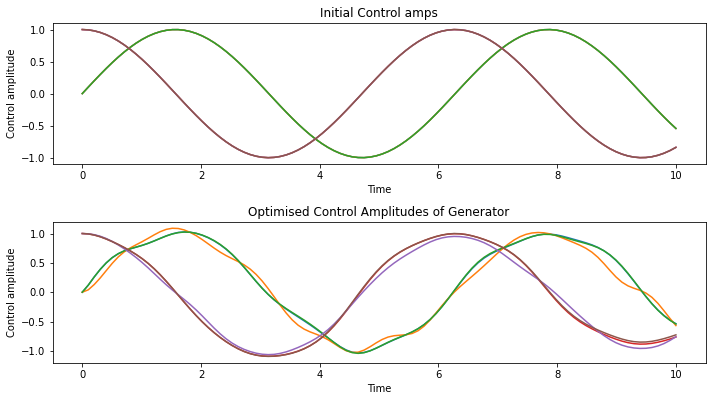

In [25]:
#labels=['X1','X2','Z1','Z2']

fig1 = plt.figure(figsize = (10,8))
ax1 = fig1.add_subplot(3, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.plot(tlist, tP[0][0][:,j])
    
ax2 = fig1.add_subplot(3, 1, 2)
ax2.set_title("Optimised Control Amplitudes of Generator")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.plot(tlist,tP[-1][-1][:, j])#, label=labels[j])
"""
ax3 = fig1.add_subplot(3, 1, 3)
ax3.set_title("Optimised Control Amplitudes of Discriminator in the last step")
ax3.set_xlabel("Time")
ax3.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax3.plot(tlist,result_dis.final_amps[:, j])#, label=labels[j])"""

#ax2.legend(ncol=n_ctrls)
#plt.suptitle("5 Qubit GRAPE BFGS Optimizer", fontsize = 20)
plt.tight_layout()
#fig1.savefig("5qubit_GRAPE_BFGS")
plt.show()